# Projekt MSP1
Cílem tohoto projektu je se seznámit s programovými nástroji využívaných ve statistice a osvojit si základní procedury. Projekt není primárně zaměřen na efektivitu využívání programového vybavení (i když úplně nevhodné konstrukce mohou mít vliv na hodnocení), ale nejvíce nás zajímají vaše statistické závěry a způsob vyhodnocení. Dbejte také na to, že každý graf musí splňovat nějaké podmínky - přehlednost, čitelnost, popisky.

V projektu budete analyzovat časy běhu šesti různých konfigurací algoritmů. Ke každé konfiguraci vzniklo celkem 200 nezávislých běhů, jejichž logy máte k dispozici v souboru [logfiles.zip](logfiles.zip).

Pokud nemáte rozchozené prostředí pro pro spouštění Jupyter notebooku, můžete využití službu [Google Colab](https://colab.google/). Jakákoliv spolupráce, sdílení řešení a podobně je zakázána!

S případnými dotazy se obracejte na Vojtěcha Mrázka (mrazek@fit.vutbr.cz).

__Odevzdání:__ tento soubor (není potřeba aby obsahoval výstupy skriptů) do neděle 22. 10. 2023 v IS VUT. Kontrola bude probíhat na Pythonu 3.10.12; neočekává se však to, že byste používali nějaké speciality a nekompatibilní knihovny. V případě nesouladu verzí a podobných problémů budete mít možnost reklamace a prokázání správnosti funkce. Bez vyplnění vašich komentářů a závěrů do označených buněk nebude projekt hodnocen!

__Upozornění:__ nepřidávejte do notebooku další buňky, odpovídejte tam, kam se ptáme (textové komentáře do Markdown buněk)

__Tip:__ před odevzdáním resetujte celý notebook a zkuste jej spustit od začátku. Zamezíte tak chybám krokování a editací, kdy výsledek z buňky na konci použijete na začátku.

__OTÁZKA K DOPLNĚNÍ:__

_Jméno a login autora_ \
Pavel Heřmann (xherma34)

## Načtení potřebných knihoven
Načtěte knihovny, které jsou nutné pro zpracování souborů a práci se statistickými funkcemi. Není dovoleno načítat jiné knihovny.

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from zipfile import ZipFile

## Načtení dat do DataFrame
Ze souboru `logfiles.zip` umístěném ve stejném adresáři načtěte data a vytvořte Pandas DataFrame.

Z logu vás budou nejvíce zajímat řádky
```
Configuration: config6
Run: 191
Time of run: 53.298725254089774
```

Můžete využít následující kostru - je vhodné pracovat přímo se ZIP souborem. Jedinou nevýhodou je to, že vám bude vracet _byte_ objekt, který musíte přes funkci `decode` zpracovat.

In [32]:
# TODO nacteni dat ze zip souboru

def load_logfile(f) -> dict:
    """Load a logfile from a file-like object and return a dict with the data."""
    data = {
        "conf": None,
        "run": None,
        "time": np.nan
    }

    for line in f:
        line = line.decode("utf-8")
        x = line.split(": ") 
        if x[0] == "Configuration" :
            data["conf"] = x[1][0:-1]
        elif x[0] == "Run" :
            data["run"] = x[1][0:-1]
        elif x[0] == "Time of run" :
            data["time"] = float(x[1][0:-1])
        

    
    return data

data = []
with ZipFile("logfiles.zip") as zf:
    for filename in zf.namelist():
        with zf.open(filename, "r") as f:
            data.append(load_logfile(f))
df = pd.DataFrame(data)
df

,conf,run,time
0,config1,0,104.967142
1,config1,1,98.617357
2,config1,2,106.476885
3,config1,3,115.230299
4,config1,4,97.658466
...,...,...,...
1195,config6,195,168.809495
1196,config6,196,159.607244
1197,config6,197,171.049799
1198,config6,198,164.478283


## Analýza a čištění dat
Vhodným způsobem pro všechny konfigurace analyzujte časy běhů a pokud tam jsou, identifikujte hodnoty, které jsou chybné. 

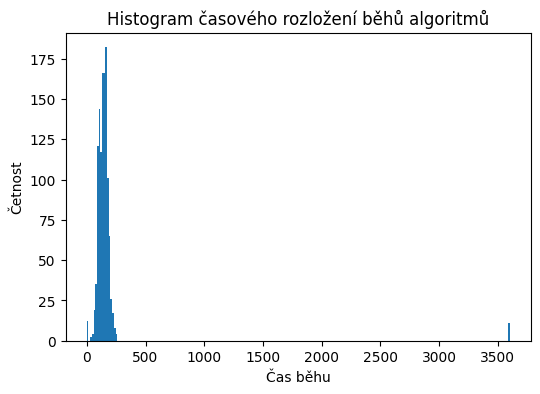

In [33]:
# TODO vykresleni grafu pro identifikace outlieru
fig, ax = plt.subplots(figsize=(6,4))

ax.hist(df["time"], bins=250)
ax.set(xlabel="Čas běhu", ylabel="Četnost")
ax.set_title("Histogram časového rozložení běhů algoritmů")

# Z histogramu jde vidět, že se většina hodnot sdružuje kolem intervalu (0,cca300)
# Dále máme pár běhů, které se nacházejí v histogarmu přesně u nuly a za 3500, tedy mimo většinu naměřených hodnot
# Z grafu je tedy viditelné, že tyto hodnoty jsou "chybné"

q1 = np.percentile(df["time"], 25)
q3 = np.percentile(df["time"], 75)

iqr = q3-q1

timeMin = pd.Series(df["time"])

#Identifikace outlieru viz. prezentace 1. democviceni slide 25
min = np.maximum(q1 - 1.5*iqr, timeMin.min())
max = np.minimum(q3 + 1.5*iqr, timeMin.max())

fig.savefig("ex1.png")

__OTÁZKA K DOPLNĚNÍ:__

_Objevily se nějaké chybné hodnoty? Proč tam jsou s ohledem na to, že se jedná o běhy algoritmů?_ \
Chybné hodnoty se objevily, z grafu lze vidět, že nalevo od sdružení většiny naměřených hodnot byl čas běhu velice nízký (u nuly na x-ové ose) a napravo od sdružení byl čas běhu velice vysoký (3500+). Tyto hodnoty jsou vůči zbytku naměřených hodnot "abnormální".\
Tyto hodnoty indikují nějaké chybné běhy(ukončené chybou) tudíž vzhledem k ostatním běhům nejsou nijak významné.

Vyčistěte dataframe `df` tak, aby tam tyto hodnoty nebyly a ukažte znovu analýzu toho, že čištění dat bylo úspěšné. Odtud dále pracujte s vyčištěným datasetem.

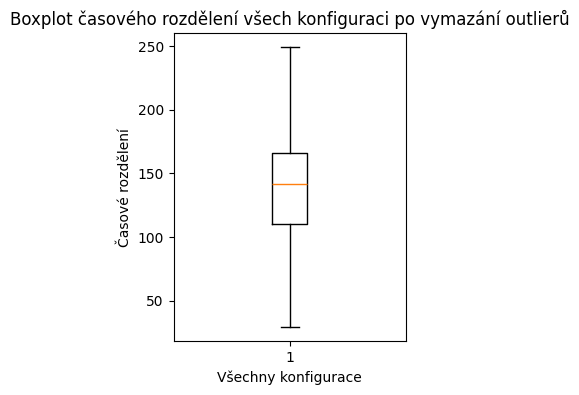

In [34]:
# TODO kod pro upravu dataframe tak, že tam tyto hodnoty nebudou:

# V předchozím bloku jsme si vypočítali hodnoty min, max, které nám značí horní a spodní outlier
# ty z data framu smažeme pomocí funkce drop
df.drop(df[df['time'] > max].index, inplace = True)
df.drop(df[df['time'] < min].index, inplace = True)


fig2, ax2 = plt.subplots(figsize=(3,4))

ax2.set(xlabel="Všechny konfigurace", ylabel="Časové rozdělení")
ax2.set_title("Boxplot časového rozdělení všech konfiguraci po vymazání outlierů")

# Po odstranění těchto hodnot si lze všimnout, že na boxplot grafu se nenachází už žádný zaznačený outlier (smazali jsme vsechny outliery)
ax2.boxplot(df["time"])
fig.savefig("ex2.png")


## Deskriptivní popis hodnot
Vypište pro jednotlivé konfigurace základní deskriptivní parametry času pro jednotlivé konfigurace.  

__TIP__ pokud výsledky uložíte jako Pandas DataFrame, zobrazí se v tabulce.

In [35]:
# TODO deskriptivni parametry

df1 = df[df['conf'] == "config1"]
df2 = df[df['conf'] == "config2"]
df3 = df[df['conf'] == "config3"]
df4 = df[df['conf'] == "config4"]
df5 = df[df['conf'] == "config5"]
df6 = df[df['conf'] == "config6"]

df1_desc = df1.describe()
df2_desc = df2.describe()
df3_desc = df3.describe()
df4_desc = df4.describe()
df5_desc = df5.describe()
df6_desc = df6.describe()

dfTable = pd.concat([df1_desc, df2_desc, df3_desc, df4_desc, df5_desc, df6_desc], axis=1)

print(dfTable)

# print("1. konfigurace: \n", df1.describe())
# print("2. konfigurace: \n", df2.describe())
# print("3. konfigurace: \n", df3.describe())
# print("4. konfigurace: \n", df4.describe())
# print("5. konfigurace: \n", df5.describe())
# print("6. konfigurace: \n", df6.describe())




             time        time        time        time        time        time
count  193.000000  197.000000  195.000000  199.000000  195.000000  196.000000
mean    99.590413  151.732975  138.616959  110.317016  182.930806  162.829359
std      9.386788   19.833198   19.867428   30.656816   27.951560   20.648193
min     73.802549   85.174653   90.567110   29.093401  107.283620  102.074892
25%     92.979469  137.995662  124.803901   88.742158  163.751700  149.917475
50%     99.865028  151.516091  138.678404  110.782732  182.883623  163.990098
75%    104.824724  163.802880  151.536291  130.665606  200.350665  177.730865
max    127.201692  227.054630  201.577616  188.971462  248.966944  208.795048


__OTÁZKA K DOPLNĚNÍ:__

_Okomentujte, co všechno můžeme z parametrů vyčíst._

**Interpretace parametrů** 
- count = Počet naměřených hodnot
- mean = Průměrný čas běhu konfigurace
- std = Rozptyl - značí jak moc jsou hodnoty rozmíštěny kolem průměru 
- min = Nejnižší naměřená hodnota
- 25% = (percentil) značí, že 25% hodnot je menších než výsledná hodnota (25% = 100, 25% hodnot je menších než 100)
- 50% = (Medián) hodnota rozděluje soubor naměřených dat uprostřed, značí tedy, že polovina naměřených hodnota je nad a polovina pod mediánem
- 75% = (percentil) značí, že 75% hodnot je menších než výsledná hodnota (75% = 100, 75% hodnot je menších než 100)
- max = Nejvyšší naměřená hodnota

**Příklad: interpretace parametrů 1. Konfigurace** \
Počet naměřených hodnot(běhů algoritmu) je 193, z toho 99.5904s je průměrný čas běhu s odchylkou 9.3867, což znamená, že většina běhů je v rozmezí (99.5904-9.3867, 99.5904+9.3867). Nejrychlejší běh trval 73.8025s a nejpomalější běh trval 127.2017s. Dále 25% běhů algoritmu trvalo méně než 92.9795s, polovina běhů trvala méně než 99.865s a polovina déle než 99.865s, dále víme, že 75% běhů trvalo méně než 104.8247s.

**Jak lze konfigurace porovnávat** \
Z těchto hodnot lze potom říci, která konfigurace v průměru je rychlejší/pomalejší. Pomocí rozptylu lze řici, která konfigurace bude mít větší výkyv v rychlosti vůči průměrnému času běhu, který má nejrychlejší/nejpomalejší běh a celkově jak jsou naměřené hodnoty rozděleny(např. ze srovnání kvartilů konfigurace 1 a 2 lze řici, že 1. konfigurace má celkově kvartilové rozdělení lepší(konfigurace bude nejspíše rychlejší) oproti 2. konfiguraci, protože například 3. kvarlit 1. konfigurace označuje, že 75% běhů byl rychlejší, než 104.8247s, zatímco v 2. konfiguraci už v 1. kvartilu vidíme, že 25% hodnot je rychlejších než 137.9956s. Což znamená, že 75% nejrychlejších běhů 1. konfigurace bylo rychlejší než 25% nejrychlejších běhů 2. konfigurace).

## Vizualizace
Vizualizujte časy běhů algoritmů v jednom kompaktním grafu tak, aby byl zřejmý i rozptyl hodnot. Zvolte vhodný graf, který pak níže komentujte.

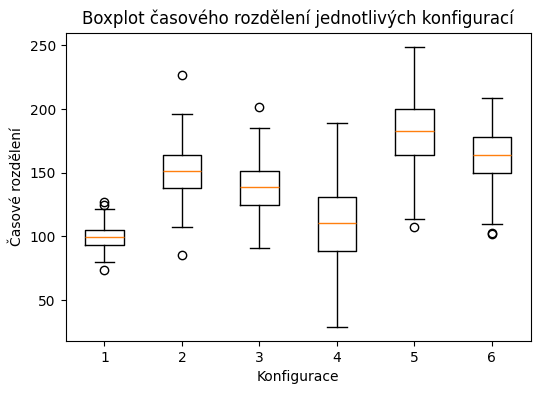

In [36]:
# TODO graf

# Ulozeni pandas serie do arraye pro budouci pracovani
timeArray1 = pd.Series(df1['time'])
timeArray4 = pd.Series(df4['time'])

# jednotlive konfigurace do box grafu
fig3, ax3 = plt.subplots(figsize=(6,4))
ax3.set(xlabel="Konfigurace", ylabel="Časové rozdělení")
ax3.set_title("Boxplot časového rozdělení jednotlivých konfigurací")

#ax2.hist(df["time"], bins = 80)
ax3.boxplot([df1['time'], df2['time'], df3['time'], df4['time'], df5['time'], df6['time']])
fig.savefig("ex3.png")

__OTÁZKA K DOPLNĚNÍ:__

_Okomentujte  výsledky z tabulky._ 

**Co vidíme** \
Vidíme, že 1. konfigurace se zdá být rychlou s menším rozložením hodnot a celkem nízkým výkyvem abnormálních hodnot(outlier). Dále se dá 4. konfigurace považovat za celkem rychlou, protože její minimum je ještě níže, než 1. konfigurace, ovšem celkově má velký rozptyl času běhů, také lze vidět, že ve 4. konfiguraci oproti 1. konfiguraci nejsou žádné abnormální hodnoty. V porovnání s 1. a 4. konfigurací vidíme, že ostatní mají minimum výše než tyto dvě a celkově většina jejich hodnot je sdružovaná výše (běhy trvaly déle). Například 2. konfigurace má vysoké rozpětí otlierů, víme tedy, že obsahuje nějaké abnormálně vyšší a nižší hodnoty.
Z konfigurací tedy dává smysl zkoumat 1. a 4. konfigurace.

## Určení efektivity konfigurací algoritmů
Nás ale zajímá, jaká konfigurace je nejrychlejší. Z výše vykresleného grafu můžeme vyloučit některé konfigurace. Existuje tam však minimálně jedna dvojice, u které nedokážeme jednoznačně určit, která je lepší - pokud nebudeme porovnávat pouze extrémní hodnoty, které mohou být dané náhodou, ale celkově. Proto proveďte vhodný test významnosti - v následující části diskutujte zejména rozložení dat (i s odkazem na předchozí buňky, variabilitu vs polohu a podobně). Je nutné každý logický krok a výběry statistických funkcí komentovat. Můžete i přidat další buňky.

Vužijte vhodnou funkci z knihovny `scipy.stats` a funkci poté __implementujte sami__ na základě základních matematických funkcí knihovny `numpy` případně i funkcí pro výpočet studentova rozložení v [scipy.stats](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.t.html). Při vlastní implementaci není nutné se primárně soustředit na efektivitu výpočtu (není potřeba využít všechny funkce numpy, můžete použít normální cykly a podobně - v hodnocení však bude zahrnuta přehlednost a neměly by se objevit jasné chyby, jako je zvýšení třídy složitosti a podobně).

__OTÁZKA K DOPLNĚNÍ:__

_Jaká data budete zkoumat? Jaké mají rozložení a parametry (např. varianci) a jaký test použijete? Jaká je nulová hypotéza? Jak se liší variabilita a poloha vybraných konfigurací?_
Budeme zkoumat 1. a 4. konfiguraci.
Víme, že např. 4. konfigurace má menší minimum (menší čas nejrychlejšího běhu), 1. kvartli 4. konfigurace zahrnuje sice medián 1. konfigurace, ale jelikož je rozpětí hodnot u 4. konfigurace větší (má větší obor hodnot), nelze jasně říci, která je lepší. K určení nám pomůže nezávislý t-test.
Nezávislý dvouvýběrový t-test dělá statistiku ze dvou souborů dat, kde tyto soubory jsou na sobě nezávislé, oba soubory mají různou velikost a mají různý rozptyl. Nulová hypotéza je potom, že 1. konfigurace je stejně dobrá nebo horší, než 4. konfigurace, výsledná p-hodnota z výpočtu nám potom pomůže zamítnout/nezamítnout nulovou hypotézu.

In [37]:
# TODO: Implementace s vyuzitim knihovni funkce
# hypoteza: conf1 je stejne dobra nebo horsi nez conf4
# p-value < 0.05 -> s vernosti 95% zamitam hypotezu
# dvouvyberovy ttest mezi dvema nezavislymi skupinami (rozlisna velikost a rozlisnou varianci)

print(stats.ttest_ind(timeArray1, timeArray4, equal_var=False, alternative="less"))



TtestResult(statistic=-4.713292868840319, pvalue=2.0843410569946737e-06, df=235.8572821440884)


__OTÁZKA K DOPLNĚNÍ:__

_Jaký je závěr statistického testu?_ \
P-hodnota je 0,000002.... \
P-hodnota < 0.05 => Zamítáme nulovou hypotézu, že je 1. konfigurace stejně dobrá nebo horší než 4. konfigurace a tedy musí platit alternativní hypotéza, že 4. konfigurace je lepší, než 1. konfigurace.

In [38]:
# TODO vlastni implementace zvoleneho testu

s1 = np.var(timeArray1, ddof=1)
s2 = np.var(timeArray4, ddof=1)
x1 = np.mean(timeArray1)
x2 = np.mean(timeArray4)
n1 = len(timeArray1)
n2 = len(timeArray4)


# vzorce viz. https://en.wikipedia.org/wiki/Student's_t-test#Exact_method_for_unequal_variances_and_sample_sizes
tsA = x1-x2
tsB = np.sqrt(((s1)/n1)+((s2)/n2))
ts = tsA/tsB

dofA = np.power((np.power(s1,2)/n1)+(np.power(s2,2)/n2),2)
dofB = (np.power((np.power(s1,2)/n1), 2)/(n1-1))+(np.power((np.power(s2,2)/n2), 2)/(n2-1))
dof = dofA/dofB


print("t-statistika: ", ts)
print("Dof: ", dof)

# get p value
pvalue = stats.t.cdf(ts, dof)
print("P-hodnota: ", pvalue)

t-statistika:  -4.713292868840319
Dof:  201.58800100071852
P-hodnota:  2.2697076502411656e-06
